In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1240 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Degree1', 'Degree2', 'Degree3']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 128, 128, 3)
[1 1 2 2 0 0 0 1 1 0 0 2 0 0 1 1 0 1 1 2 1 1 1 1 1 2 1 1 1 0 0 0]


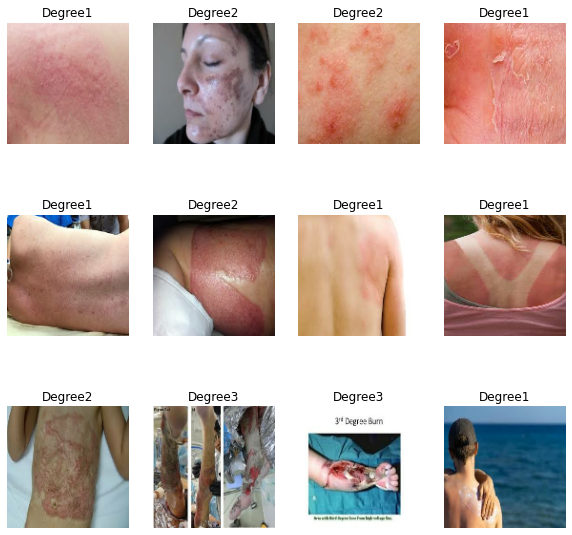

In [12]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [13]:
len(dataset)

39

In [14]:
train_size = 0.8
len(dataset)*train_size

31.200000000000003

In [15]:
train_ds = dataset.take(31)
len(train_ds)

31

In [16]:
test_ds = dataset.skip(31)
len(test_ds)

8

In [17]:
val_size=0.1
len(dataset)*val_size

3.9000000000000004

In [18]:
val_ds = test_ds.take(4)
len(val_ds)

4

In [19]:
test_ds = test_ds.skip(4)
len(test_ds)

4

In [20]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [21]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [22]:
len(train_ds)

31

In [23]:
len(test_ds)

5

In [24]:
len(val_ds)

3

In [25]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])


In [27]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (2,2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (2,2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 127, 127, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 63, 63, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 62, 62, 64)          8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 31, 31, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 30, 30, 64)         

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
31/31 [==============================] - 7s 200ms/step - loss: 1.0353 - accuracy: 0.4214 - val_loss: 1.0273 - val_accuracy: 0.4688
Epoch 2/50
31/31 [==============================] - 5s 170ms/step - loss: 1.0186 - accuracy: 0.4335 - val_loss: 1.0300 - val_accuracy: 0.4688
Epoch 3/50
31/31 [==============================] - 5s 174ms/step - loss: 1.0026 - accuracy: 0.4486 - val_loss: 0.9972 - val_accuracy: 0.4375
Epoch 4/50
31/31 [==============================] - 5s 172ms/step - loss: 0.9263 - accuracy: 0.5020 - val_loss: 1.0754 - val_accuracy: 0.4479
Epoch 5/50
31/31 [==============================] - 5s 170ms/step - loss: 0.9062 - accuracy: 0.5121 - val_loss: 0.8616 - val_accuracy: 0.6146
Epoch 6/50
31/31 [==============================] - 5s 173ms/step - loss: 0.9041 - accuracy: 0.5363 - val_loss: 0.9340 - val_accuracy: 0.5521
Epoch 7/50
31/31 [==============================] - 5s 173ms/step - loss: 0.8776 - accuracy: 0.5665 - val_loss: 0.8516 - val_accuracy: 0.5729
Epoch 